# Question 7

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
root = './A2_resources/'

In [3]:
def read(path, arg = cv2.IMREAD_UNCHANGED):
    args = {'gray' : cv2.IMREAD_GRAYSCALE, 'unchanged' : cv2.IMREAD_UNCHANGED, 'color' : cv2.IMREAD_COLOR}
    return cv2.imread(path, args[arg])

In [4]:
def strided(img, kernel):
    img = img.astype('float32')
    img = np.pad(img, (np.int16((kernel.shape[0]-1)/2), np.int16((kernel.shape[1]-1)/2)), 'reflect')
    expanded_input = np.lib.stride_tricks.as_strided(
    img,
    shape=(
        img.shape[0] - kernel.shape[0] + 1,
        img.shape[1] - kernel.shape[1] + 1,
        kernel.shape[0],
        kernel.shape[1],
    ),
    strides=(
        img.strides[0],
        img.strides[1],
        img.strides[0],
        img.strides[1],
    )
)
    return expanded_input

## Part 1
### Cross bilateral filter
- Filter is made from reference image and is applied on the image to enhanced

In [5]:
def  crossbilateralFilter(img, ref, window, sigma_r, sigma_d):
    img = img.astype('float32')
    ref = ref.astype('float32')
    
    arr = np.arange(start = -(window//2), stop = window//2+1)
    xv, yv = np.meshgrid(arr, arr)
    domain_filter = np.exp(-(np.power(xv,2)+np.power(yv,2))/(2*np.power(sigma_d,2)))
    
    expanded_input = strided(ref, np.ones((window, window)))
    img_expanded = strided(img, np.ones((window, window)))
    out = expanded_input - strided(ref, np.ones((1,1)))
    exp_out = np.exp(-np.power(out,2)/(2*(np.power(sigma_r,2))))
    filters = np.multiply(exp_out, domain_filter)
    app = np.multiply(filters, img_expanded)
    app = np.sum(np.sum(app, axis = 2), axis = 2)/(np.sum(np.sum(filters, axis = 2), axis= 2))

    return np.uint8(np.clip(app,0,255))

In [6]:
def crossBilateral(img, ref, window, sigma_r, sigma_d):
    if len(img.shape)>2:
        out = crossbilateralFilter(img[:,:,0], ref[:,:,0], window, sigma_r, sigma_d)
        for i in range(1,img.shape[2]):
            out = np.dstack((out,crossbilateralFilter(img[:,:,i], ref[:,:,i], window, sigma_r, sigma_d)))
        return out
    else:
        return crossbilateralFilter(img, ref, window, sigma_r, sigma_d)

In [7]:
ref = read(root+'pots_flash.jpg', 'color')
im = read(root+'pots_no_flash.jpg', 'color')

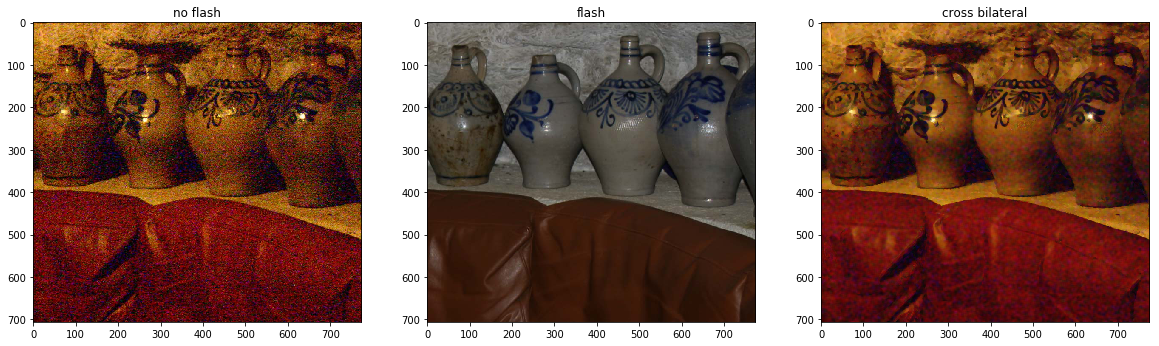

In [8]:
s = 300
r = 3
out = crossBilateral(im, ref, 7, r, s)

_,plots = plt.subplots(1,3,figsize = (20,20))
plots[0].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plots[0].set_title('no flash')
plots[1].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
plots[1].set_title('flash')
plots[2].imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plots[2].set_title('cross bilateral')
plt.show()

## Part 2
### Inverse Bilateral filter

- If we want to preserve the shading information of the image while blurring the edges, we can develop an inverse bilateral filter. For that we use the following algo,
    - For inverse bilateral, the range filter is formed by using contrast. Higher contrast mean more weight to pixel.
    - Calculating contrast = $ 256^2 - (I_1 - I_2)^2 $
    - Hence the range  filter will be $$ F_r = e^{-\frac{(256^2 - (I_1 - I_2)^2)}{2*\sigma^2}}  $$
- Explaination: In case of bilateral filter, if the pixel is on top of the step edge then the range filter gives no response to it and gives high response to the bottom, but since here we are using contrast of pixel, thus the top of step edge will give high response with range filter resulting in its gaussian blurring.